<a href="https://colab.research.google.com/github/uprestel/AutoNeRF/blob/master/pose_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pose estimation
In this Notebook we 
* load a trained VAE, a trained NeRF to generate images
* Next we generate a pose and an image at that pose 
* Finally, we learn to translate between a pose and a prior given the latent vector of our image


### Load imports

In [1]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

!git clone https://github.com/uprestel/AutoNeRF.git

import AutoNeRF.data.data
import AutoNeRF.models.cinn as cinn
import AutoNeRF.models.blocks as blocks
import AutoNeRF.models.loss as cinn_loss
import AutoNeRF.models.nerf as nerf
import AutoNeRF.models.vae
import AutoNeRF.util.utils
from AutoNeRF.util.utils import show
#import AutoNeRF.cam_util
from AutoNeRF.util.transforms import random_rotation, look_at_rotation

import time
import os
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from google.colab import drive
drive.mount('/gdrive', force_remount=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Cloning into 'AutoNeRF'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 445 (delta 33), reused 0 (delta 0), pack-reused 370
Receiving objects: 100% (445/445), 41.90 MiB | 28.83 MiB/s, done.
Resolving deltas: 100% (229/229), done.
Mounted at /gdrive


## Load trained NeRF model

In [3]:
model = nerf.TinyNerfModel().to(device)
model.load_state_dict(torch.load("/gdrive/My Drive/nerf_lego.pt"))
model.eval()

TinyNerfModel(
  (layer1): Linear(in_features=39, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=32, bias=True)
  (layer5): Linear(in_features=32, out_features=4, bias=True)
)

## cINN training
Now that our VAE is ready, we are now learning a normalizing flow to generate new samples

In [ ]:
latent_space = 64
batch_size = 32
epochs = 40


def transform(image):
    image = (AutoNeRF.util.utils.swap_channels(image))
    #image = F.interpolate(image, size=64)
    return image


# We create an invertible neural Network with the following properties:
# * Our conditional input (the latent space vector) is 64-dimensional
# * The hidden dimension is 3 * the size of the number of components in our pose matrix (12 * 3)
# * The translations and scalings have the depth 5
# * We have 14 alternating coupling layers
tau = cinn.ConditionalTransformer(
    in_channels = 12,
    cond_channels = latent_space,
    hidden_dim = 12 * 3,
    hidden_depth = 5,
    n_flows = 14
).to(device)



# OPTIMIZER: AMSGRAD OR ADAM WITH 1e-2
optimizer = torch.optim.Adam(params=tau.parameters(), lr=1e-4)


pth="/gdrive/My Drive/temp_dataset_lego_new3.pt.npz"
dataset = AutoNeRF.data.data.AutoNeRF_Dataset(pth)
vae = AutoNeRF.models.vae.VAE(in_channels = 3, latent_dim=latent_space).to(device)
vae.load_state_dict(torch.load("/gdrive/My Drive/vae_lego.pt"))
vae.eval()


dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
loss = cinn_loss.Loss(None)

for epoch in range(epochs):
    print("--- starting epoch %s ---"%epoch)
    for i, sample in enumerate(dataloader):
        optimizer.zero_grad()
        
        images, poses = sample
        images = transform(images).to(device)

        poses = poses.view(batch_size, -1)
        poses_red = poses[:, :12].to(device)
        poses_red = poses_red[:,:,None,None]
        _,_,_,z = vae(images)
        z = z[:,:,None,None]
        #print(poses, poses_red)
        #print(z.shape, poses_red.shape)
        zz, logdet = tau(poses_red, z)
        l = loss(zz, logdet)
        l.backward()
        
        optimizer.step()
        if i % 100 == 0:
            print(l.item())

# Save / Load the model

In [52]:
torch.save(tau.state_dict(), "/gdrive/My Drive/cinn_lego_pose.pt")

In [ ]:
latent_space = 64
tau = cinn.ConditionalTransformer(
    in_channels = 12,
    cond_channels = latent_space,
    hidden_dim = 12 * 3,
    hidden_depth = 5,
    n_flows = 14
).to(device)
tau.load_state_dict(torch.load("/gdrive/My Drive/cinn_lego_pose.pt"))
tau.eval()


vae = AutoNeRF.models.vae.VAE(in_channels = 3, latent_dim=latent_space).to(device)
vae.load_state_dict(torch.load("/gdrive/My Drive/vae_lego.pt"))
vae.eval()


# Pose estimation example
In this example we will do the following:
* Generate a new pose and render a corresponding image using NeRF
* Estimate the pose using the cINN 


tensor(4.0311, device='cuda:0') tensor([0., 0., 0.], device='cuda:0')


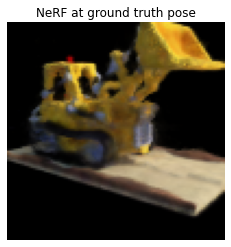

Ground truth pose:
 tensor([[ 0.6173,  0.1473, -0.7728, -2.3924],
        [-0.7867,  0.1156, -0.6064, -1.8773],
        [ 0.0000,  0.9823,  0.1873,  0.5797],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')
---------------
 Predicted pose: 
 tensor([[ 6.4013e-01,  1.3830e-01, -7.6191e-01, -2.4775e+00],
        [-8.3339e-01,  9.3684e-02, -6.5450e-01, -2.0222e+00],
        [-8.8208e-06,  9.9419e-01,  1.2960e-01,  3.7162e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0',
       grad_fn=<CopySlices>)


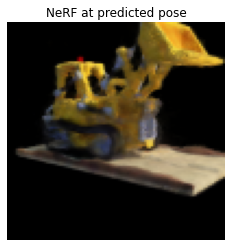

tensor(3.0958, device='cuda:0') tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>)


In [61]:
dataset = AutoNeRF.data.data.AutoNeRF_Dataset("/gdrive/My Drive/chair.npz")

def get_new_pose(center, radius):
    """
    generates a new pose / perspective for the NeRF model
    """

    rot = random_rotation().to(device)
    unit_x = torch.tensor([1.,0.,0.]).to(device)
    new_t = center + radius*(rot @ unit_x)

    new_t[2] = torch.abs(new_t[2])


    cam_rot = look_at_rotation(at=new_t.unsqueeze(dim=0), 
                               camera_position=center.unsqueeze(dim=0),up=UP) #tform_cam2world[0, :3, :3]#

    #cam_rot = torch.transpose(cam_rot, 1,2)
    transform = torch.zeros((4,4))#.to(device)
    
    transform[:3, :3] = cam_rot
    transform[:3, 3] = new_t
    transform[3, 3] = 1
    #print(look_at_rotation(center))
    return transform

def get_thresholds(r):
    diff = r - SCENE_RADIUS
    tn = diff
    tf = diff + 2*SCENE_RADIUS
    return tn, tf

def show(image, permutation=(0,1,2), title=""):
    grid_img = torchvision.utils.make_grid(image, nrow=5)
    plt.imshow(grid_img.permute(permutation))
    plt.title(title)
    plt.axis('off')
    plt.show()

def to_pose(p):
    new_pose = torch.zeros((4,4)).to(device)
    Rt = p.reshape((3,4))
    new_pose[:3,:4] = Rt
    new_pose[3,3] = 1.
    return new_pose


# ------ First load parameters for NeRF from the dataset ------
images = torch.from_numpy(dataset.images).to(device)
focal_length = torch.from_numpy(dataset.focal_length).to(device)
poses = torch.from_numpy(dataset.poses).to(device)

height, width = images.shape[1:3]

UP = torch.tensor([0.,0.,1.]).unsqueeze(dim=0).to(device)
translation = torch.tensor(dataset.poses[:, :3,3]).to(device)

center = torch.zeros(3).to(device)
radius = torch.norm(translation[0] - center, p=2)
height, width = 100,100
print(radius, center)

SCENE_RADIUS = 2


num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: nerf.positional_encoding(x, num_encoding_functions=num_encoding_functions)


# ------ Now we generate a pose and a corresponding image using NeRF ------
depth_samples_per_ray = 240

r = torch.tensor(np.random.uniform(radius.item()-1, radius.item()+1)).to(device)
near_thresh, far_thresh = get_thresholds(r)

new_pose = get_new_pose(center, r).to(device)
predicted = nerf.nerf_prediction(model, height, width, focal_length, new_pose,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encode, nerf.get_minibatches)

show(predicted.cpu(), title="NeRF at ground truth pose")

# ------ Next we estimate the pose from our image ------
predicted = predicted[None, :,:,:]
image = (AutoNeRF.util.utils.swap_channels(predicted))

_,_,_,z = vae(image)
z = z[:,:,None,None]
pose_red = new_pose[:, :12].to(device)
pose_red = pose_red[:,:,None,None]

zz = torch.randn(batch_size, 12).to(device)
zz = zz[:,:, None, None]

# ------ Finally, we compare the results ------
print("Ground truth pose:\n",new_pose)
pred_pose = tau.reverse(zz, z).squeeze(-1).squeeze(-1)
pred_pose = to_pose(pred_pose)
print("---------------\n Predicted pose: \n", pred_pose)

predicted = nerf.nerf_prediction(model, height, width, focal_length, pred_pose,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encode, nerf.get_minibatches)

show(predicted.cpu(), title="NeRF at predicted pose")
m = torch.nn.functional.mse_loss(pred_pose, new_pose)
print(r,m)

# Collect pose estimation error
Now we will vary vary the radius beyond the interval $[r-1, r+1]$, namely $[r-1.5, r+4]$ and examine how the MSE grows

In [63]:
# ------ First load parameters for NeRF from the dataset ------
images = torch.from_numpy(dataset.images).to(device)
focal_length = torch.from_numpy(dataset.focal_length).to(device)
poses = torch.from_numpy(dataset.poses).to(device)

height, width = images.shape[1:3]

UP = torch.tensor([0.,0.,1.]).unsqueeze(dim=0).to(device)
translation = torch.tensor(dataset.poses[:, :3,3]).to(device)

center = torch.zeros(3).to(device)
radius = torch.norm(translation[0] - center, p=2)
height, width = 100,100
print(radius, center)

SCENE_RADIUS = 2

num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: nerf.positional_encoding(x, num_encoding_functions=num_encoding_functions)


# ------ Now we generate a pose and a corresponding image using NeRF ------
depth_samples_per_ray = 240
n_samples = 10
mses = []

radii = np.linspace(radius.item()-1.5, radius.item()+4, 100)
for r in radii:

    near_thresh, far_thresh = get_thresholds(r)
    batch_mse = []
    for _ in range(n_samples):
        new_pose = get_new_pose(center, r).to(device)
        # ------ Next we estimate the pose from our image ------
        predicted = nerf.nerf_prediction(model, height, width, focal_length, new_pose,
                                near_thresh, far_thresh, depth_samples_per_ray,
                                encode, nerf.get_minibatches)
        predicted = predicted[None, :,:,:]
        image = (AutoNeRF.util.utils.swap_channels(predicted))

        _,_,_,z = vae(image)
        z = z[:,:,None,None]
        pose_red = new_pose[:, :12].to(device)
        pose_red = pose_red[:,:,None,None]

        zz = torch.randn(batch_size, 12).to(device)
        zz = zz[:,:, None, None]

        # ------ Finally, we compare the results ------
        
        pred_pose = tau.reverse(zz, z).squeeze(-1).squeeze(-1)
        pred_pose = to_pose(pred_pose)

        m = torch.nn.functional.mse_loss(pred_pose, new_pose)
        #print(r,m.item())
        batch_mse.append(m.item())

    batch_mse = np.array(batch_mse).mean()
    print("MSE", batch_mse, "at radius ", r)
    mses.append(batch_mse)

tensor(4.0311, device='cuda:0') tensor([0., 0., 0.], device='cuda:0')
MSE 0.10305003253743053 at radius  2.5311288833618164
MSE 0.10437208153307438 at radius  2.5866844389173718
MSE 0.07330815065652133 at radius  2.6422399944729276
MSE 0.033163945144042375 at radius  2.697795550028483
MSE 0.047682674555107954 at radius  2.7533511055840387
MSE 0.05491557081695646 at radius  2.808906661139594
MSE 0.019311887491494418 at radius  2.86446221669515
MSE 0.008749587787315249 at radius  2.9200177722507052
MSE 0.006170900881988928 at radius  2.975573327806261
MSE 0.009469025279395282 at radius  3.0311288833618164
MSE 0.009633661439875141 at radius  3.0866844389173718
MSE 0.005924218348809518 at radius  3.1422399944729276
MSE 0.010738415678497404 at radius  3.197795550028483
MSE 0.004084671183954924 at radius  3.2533511055840387
MSE 0.0044416050775907935 at radius  3.308906661139594
MSE 0.00660671200894285 at radius  3.3644622166951494
MSE 0.0025200778152793648 at radius  3.4200177722507052
MSE 0

Text(0, 0.5, 'MSE')

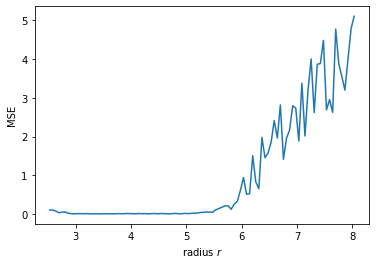

In [69]:
plt.plot(radii,mses)
plt.xlabel("radius $r$")
plt.ylabel("MSE")